# Зображення як багтовимірні масиви та підготовка зображеннь до подальшого аналіщу.

In [8]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

import skimage  # scikit-image

Корекція фонової інтенсивності

Оформлення всіх кроків корекції фонової інтенсивності у функцію

In [1]:
def background_correction(input_img:np.ndarray, background_percentile:float=1):
    back_int = np.percentile(input_img, background_percentile)
    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)
    return corr_img.astype(input_img.dtype)

NameError: name 'np' is not defined

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def select_region(input_img:np.ndarray,y1,y2,x1,x2):
    crop_image = input_img[y1:y2,x1:x2]
    plt.figure(figsize=(5,5))
    plt.imshow(crop_image, cmap='Greys_r')
    return crop_image.astype(input_img.dtype)

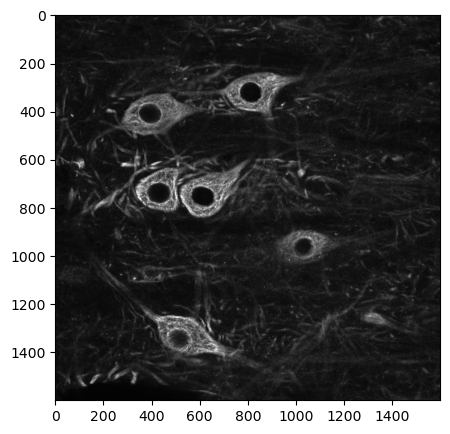

In [5]:
import tifffile as tiff
image = tiff.imread('../demo_data/2D_grey_matter_neurofilaments.tif')
plt.figure(figsize=(5,5))
plt.imshow(image, cmap='Greys_r')

In [ ]:
def background_correction(input_img:np.ndarray, background_percentile:float =1):
    back_int = np.percentile(input_img, background_percentile)
    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)
    return corr_img.astype(input_img.dtype)

Acridine Orange images were acquired using a 20× objective on the Cytation 5 imaging system. Image acquisition utilized the following LED cube channels:
1. GFP channel (excitation/emission = 469/525 nm) for the visualization of nuclei, nucleoli, and cytoplasm;
2. PI channel (excitation/emission = 531/647 nm) for the detection of acidic vesicles.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def crop_function(input_img: np.ndarray, x1, x2, y1, y2):
    
    crop_image = input_img[y1:y2, x1:x2]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(input_img)
    
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, 
        linewidth=2, edgecolor='red', facecolor='none'
    )
    
    ax[0].add_patch(rect)
    ax[0].set_title("Original Image (ROI highlighted)")
    
    ax[1].imshow(crop_image)
    ax[1].set_title("Cropped ROI")
    
    plt.tight_layout()
    plt.show()
    
    return crop_image.astype(input_img.dtype)

In [10]:
import tifffile as tiff 
GFP =  tiff.imread("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/B8_01_1_9_GFP_001.tif")
PI =  tiff.imread("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/B8_01_2_9_Propidium Iodide_001.tif")

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def background_correction(input_img: np.ndarray, background_percentile: float = 1):
  

    back_int = np.percentile(input_img, background_percentile)

    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(input_img, cmap='Greys_r')
    ax[0].set_title("Original Image")

    ax[1].imshow(corr_img, cmap='Greys_r')
    ax[1].set_title(f"Background-corrected (−{background_percentile}th percentile)")


    plt.tight_layout()
    plt.show()

    return corr_img.astype(input_img.dtype)


2. Shadding correction

In [32]:
import numpy as np
from tifffile import imread, imwrite
from scipy.ndimage import gaussian_filter

def estimate_flatfield(image_paths, sigma_px=60):
    """
    image_paths: list of TIFF paths from the SAME channel (10–20+ fields).
    sigma_px: Gaussian blur in pixels (50–100 typical for HCS fields).
    returns: float32 flat-field with median ~ 1.0
    """
    stack = [imread(p).astype(np.float32) for p in image_paths]
    med = np.median(np.stack(stack, axis=0), axis=0)       # multiplicative pattern
    ff  = gaussian_filter(med, sigma=sigma_px)             # smooth to illumination field
    # guard against zeros and normalize
    ff[ff <= 1e-6] = np.median(ff[ff > 0])
    ff /= np.median(ff)
    return ff.astype(np.float32)

In [43]:
from pathlib import Path

# 1. Get ~10–20 representative fields from one channel (e.g., GFP)
data_dir = Path("/Users/romankoval/data/GFP_train/")
image_paths = sorted(data_dir.glob("*.tif"))[:20]  # adjust number and extension

# 2. Estimate flat-field
ff = estimate_flatfield(image_paths, sigma_px=60)




In [44]:
def apply_flatfield(img, ff):
    """
    Divide by flat-field and rescale back to original dtype range (16-bit safe).
    """
    out = img.astype(np.float32) / ff
    if np.issubdtype(img.dtype, np.integer):
        info = np.iinfo(img.dtype)
        out = np.clip(out, 0, info.max).astype(img.dtype)
    else:
        out = out.astype(img.dtype)
    return out

In [48]:
img_corr = GFP.astype(np.float32) / ff
img_corr = np.clip(img_corr, 0, np.iinfo(np.uint16).max).astype(np.uint16)

In [47]:
apply_flatfield(GFP, ff)


array([[ 6863,  6746,  6712, ...,  5014,  4554,  4586],
       [ 6712,  6746,  6561, ...,  4649,  5062,  4602],
       [ 6611,  6443,  6863, ...,  4887,  4983,  5014],
       ...,
       [ 9934, 10611, 10763, ...,  6024,  5788,  5838],
       [10188,  9951, 10865, ...,  5636,  5855,  5551],
       [ 9934, 10357, 10780, ...,  5788,  6108,  5889]],
      shape=(904, 1224), dtype=uint16)

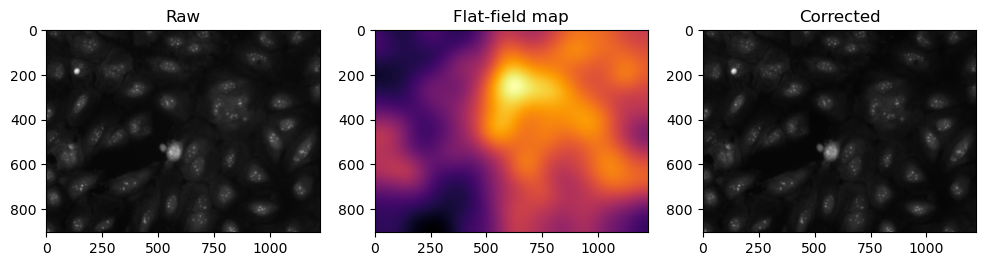

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(GFP, cmap='gray'); plt.title("Raw")

plt.subplot(1,3,2)
plt.imshow(ff, cmap='inferno'); plt.title("Flat-field map")

plt.subplot(1,3,3)
plt.imshow(img_corr, cmap='gray'); plt.title("Corrected")
plt.show()


3. Background correction

In [23]:
import numpy as np
import tifffile as tiff
import skimage
import matplotlib.pyplot as plt

def background_correction(input_img: np.ndarray, radius: int = 50):
    """
    Performs background correction using rolling-ball algorithm from scikit-image.
    Visualizes raw, background, and corrected images side-by-side.
    """
    # Compute background
    background_img = skimage.restoration.rolling_ball(input_img, radius=radius)
    corr_img = input_img - background_img
    corr_img = corr_img.clip(min=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(input_img, cmap='gray')
    axes[0].set_title('Raw image')

    axes[1].imshow(background_img, cmap='gray')
    axes[1].set_title('Background')

    axes[2].imshow(corr_img, cmap='gray')
    axes[2].set_title('Corrected')

    plt.tight_layout()
    plt.show()
    
    return corr_img.astype(input_img.dtype)


?Чому при збільшенні радіусу подовжується час виконання команди, для 300 = майже 8 хв?

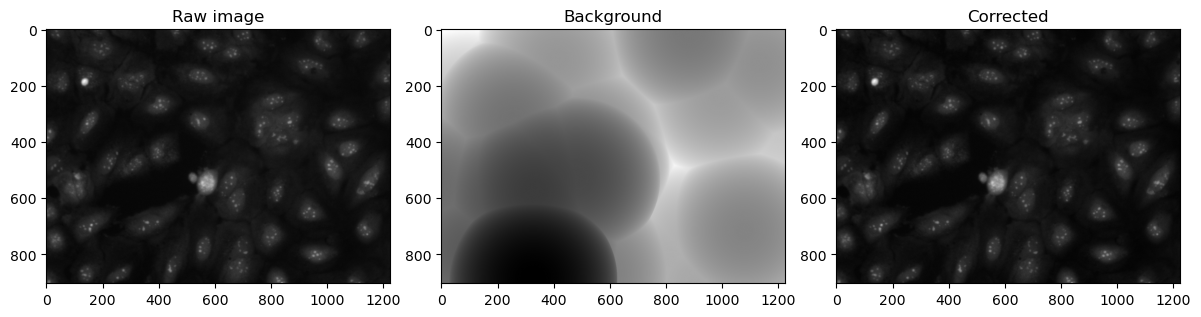

In [31]:
GFP_cor = background_correction(GFP, 300)

array([[6160, 6000, 6880, ..., 7520, 6960, 7424],
       [5968, 6064, 6032, ..., 7952, 7280, 7568],
       [5952, 6000, 5872, ..., 7360, 7008, 7072],
       ...,
       [5136, 5600, 5168, ..., 4976, 4688, 5152],
       [5568, 4896, 5456, ..., 4640, 4816, 4736],
       [5312, 5344, 5216, ..., 4400, 4704, 4976]],
      shape=(200, 200), dtype=uint16)

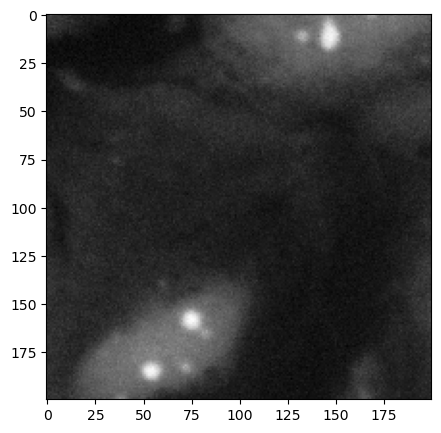

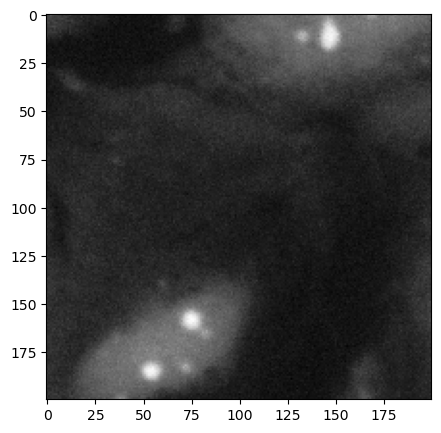

In [30]:
select_region(GFP_cor, 700,900, 200,400)
select_region(GFP, 700,900, 200,400)

In [2]:
import numpy as np
from tifffile import imread, imwrite
from scipy.ndimage import gaussian_filter
from glob import glob
from pathlib import Path

def estimate_flat_dark(image_paths, sigma_px=60):
    """Estimate flat-field (multiplicative) and dark (additive) from many frames."""
    stack = [imread(p).astype(np.float32) for p in image_paths]
    med  = np.median(np.stack(stack, axis=0), axis=0)   # robust to cells moving
    dark = np.percentile(np.stack(stack, axis=0), 1, axis=0)  # near-min as additive
    flat = gaussian_filter(med, sigma=sigma_px)         # smooth illumination field
    flat = np.clip(flat, np.median(flat[flat>0])*0.1, None)   # guard against zeros
    # normalize flat so its median is 1
    flat /= np.median(flat)
    return flat.astype(np.float32), dark.astype(np.float32)

def apply_correction(img, flat, dark):
    corr = (img.astype(np.float32) - dark) / flat
    # rescale back to original dtype range
    corr -= corr.min()
    corr *= (np.iinfo(img.dtype).max / max(1e-6, corr.max()))

    return corr.astype(np.uint16)

In [2]:
paths = sorted(glob("/Users/romankoval/data/GFP_train/*.tif"))
flat, dark = estimate_flat_dark(paths, sigma_px=60)

In [62]:
img = tiff.imread("/Users/romankoval/BioInUA_2025_img_analysis/course_data/my_data/B8_01_1_9_GFP_001.tif")
corr_image = apply_correction(img, flat, dark)


Text(0.5, 1.0, 'Corrected Image')

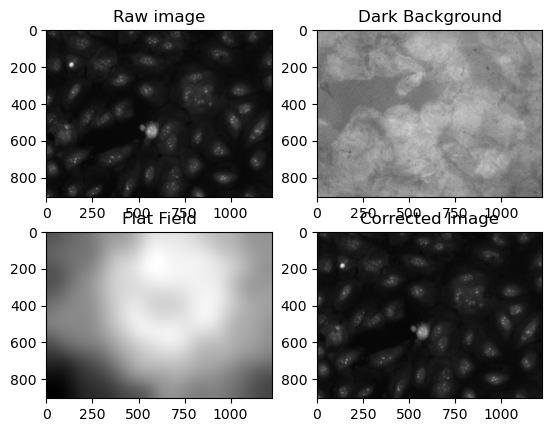

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Raw image')

axes[0, 1].imshow(dark, cmap='gray')
axes[0, 1].set_title('Dark Background')

axes[1, 0].imshow(flat, cmap='gray')
axes[1, 0].set_title('Flat Field')

axes[1, 1].imshow(corr_image, cmap='gray')
axes[1, 1].set_title('Corrected Image')